In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
absolute_path_to_repo_root = None
os.chdir(absolute_path_to_repo_root)
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
from pathlib import Path
import matplotlib.pyplot as plt
from src.sequences import KeypointsVectorToLetters, KeypointsImageToLetters

2023-05-21 20:06:13.588211: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 20:06:13.833515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 20:06:13.835543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 20:06:14.939801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


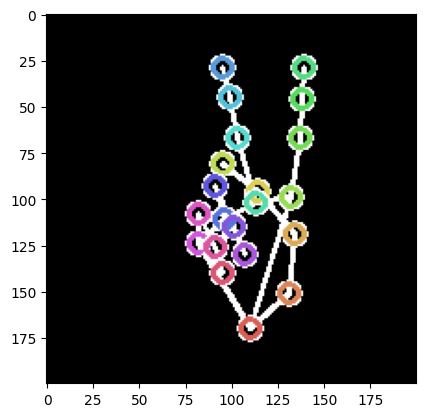

In [3]:
train_dir = Path('data/asl_alphabet_train')
sequence = KeypointsImageToLetters(list(train_dir.iterdir()), batch_size=32, labels=[d.stem for d in train_dir.iterdir()])
sample_keypoints = sequence[0][0][0]
plt.imshow(sample_keypoints, cmap='gray')

In [4]:
dnn_model = tf.keras.Sequential()
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=sample_keypoints.shape,
pooling='avg',classes=len(sequence.labels_map),
weights='imagenet')
for layer in imported_model.layers:
    layer.trainable=False

dnn_model.add(imported_model)
dnn_model.add(tf.keras.layers.Flatten())
dnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(len(sequence.labels_map), activation='softmax'))
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 29)                14877     
                                                                 
Total params: 24,651,677
Trainable params: 1,063,965
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:

wandb.init(project="sign_language_recognition")

dnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

epochs = 25
callbacks = []
if wandb.run:
    callbacks.append(WandbCallback())

dnn_model.fit(sequence, epochs = epochs, callbacks=callbacks)

wandb.finish()

In [ ]:
dnn_model.save('models/keypoints_image_to_letters.h5')